In [ ]:
# Import logistic function that doesn't explode outside a 64 bit float
from scipy.special import expit as sigmoid
from numpy import zeros, zeros_like, tanh, exp, sum, dot, sqrt, log, argmax, concatenate as concat, copy, clip
from numpy.random import randn


# derivative of sigmoid function
def dsigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

# derivative of hyperbolic tangent


def dtanh(z):
    return 1 - tanh(z) ** 2

# probability function


def softmax(z):
    return exp(z) / sum(exp(z))

# cross entropy loss


def cross_ent(p, y):
    return -log(p[y])


class Cell:
    
    def __init__(self, n, d, rnn):
        """Pass the input size (n) and memory cell size (d), create hidden state of size d, pass rnn (self)"""
        self.n, self.d, self.h, self.z, z = n, d, zeros((d, 1)), n + d, n + d
        self.rnn = rnn


    def feedforward(self, x, c_, h_):
        """Pass an input of size n, the previous hidden state(ht), and the previous cell state(c)"""
        n, d = self.n, self.d
        Wi, Wf, Wo, Wc, Wy = self.rnn.Wi, self.rnn.Wf, self.rnn.Wo, self.rnn.Wc, self.rnn.Wy
        bi, bf, bo, bc, by = self.rnn.bi, self.rnn.bf, self.rnn.bo, self.rnn.bc, self.rnn.by

        index = x       # one hot encoding
        x = zeros((n, 1))
        x[index] = 1
        g = concat((x, h_))         # input g is input x + previous hidden state

        it = sigmoid(dot(Wi.T, g) + bi)     # gate activations
        ft = sigmoid(dot(Wf.T, g) + bf)
        ot = sigmoid(dot(Wo.T, g) + bo)
        ct = tanh(dot(Wc.T, g) + bc)        # non linearity activation
        c = ft * c_ + it * ct       # cell state

        ht = ot * tanh(c)       # squashed hidden state
        yt = dot(Wy.T, ht) + by     # output state
        p = softmax(yt)     # call softmax, get probability

        self.c_, self.h_ = c_, h_
        self.it, self.ft, self.ot, self.ct = it, ft, ot, ct
        self.c, self.ht, self.yt, self.p, self.g = c, ht, yt, p, g

        return ht, c


    def backpropagate(self, y, ht1, ct1):

        n, d = self.n, self.d
        Wi, Wf, Wo, Wc, Wy = self.rnn.Wi, self.rnn.Wf, self.rnn.Wo, self.rnn.Wc, self.rnn.Wy
        dWi, dWf, dWo, dWc, dWy = self.rnn.dWi, self.rnn.dWf, self.rnn.dWo, self.rnn.dWc, self.rnn.dWy
        dbi, dbf, dbo, dbc, dby = self.rnn.dbi, self.rnn.dbf, self.rnn.dbo, self.rnn.dbc, self.rnn.dby
        c_, h_ = self.c_, self.h_
        it, ft, ot, ct = self.it, self.ft, self.ot, self.ct
        c, ht, yt, p = self.c, self.ht, self.yt, self.p
        g = self.g

        dy = copy(p)
        dy[y] -= 1

        loss = cross_ent(p, y)

        dh = dot(Wy, dy) + ht1
        dh = clip(dh, -6, 6)

        do = tanh(c) * dh
        do = dsigmoid(ot) * do

        dc = ot * dh * dtanh(c)
        dc = dc + ct1
        dc = clip(dc, -6, 6)

        df = c_ * dc
        df = dsigmoid(ft) * df

        di = ct * dc
        di = dsigmoid(it) * di

        dct = it * dc
        dct = dtanh(ct) * dct

        dWf += dot(g, df.T)
        dWi += dot(g, di.T)
        dWo += dot(g, do.T)
        dWc += dot(g, dc.T)
        dWy += dot(ht, dy.T)

        dbf += df
        dbi += di
        dbo += do
        dbc += dc
        dby += dy

        dxi = dot(Wi, di)
        dxf = dot(Wf, df)
        dxo = dot(Wo, do)
        dxc = dot(Wc, dct)

        dx = dxf + dxi + dxo + dxc

        dht1 = dx[n:]
        dct1 = ft * dc

        return loss, dht1, dct1


# RNN class
class RNN:

    def __init__(self, n, d, RL, LR):
        """Pass input size (n), number of memory cells (d), recurrence length (RL), and learning rate (LR)"""
        self.n, self.d, self.z, z = n, d, n + d, n + d
        self.d = d
        self.z, z = n + d, n + d
        self.RL = RL
        self.LR = LR

        self.x = []

        self.Cells = [Cell(n, d, self)]

        self.Wi, self.Wf, self.Wo, self.Wc, self.Wy = randn(z, d) / sqrt(z / 2), randn(z, d) / sqrt(
            z / 2), randn(z, d) / sqrt(z / 2), randn(z, d) / sqrt(z / 2), randn(d, n) / sqrt(d / 2)
        self.bi, self.bf, self.bo, self.bc, self.by = randn(
            d, 1), randn(d, 1), randn(d, 1), randn(d, 1), randn(n, 1)
        self.dWi, self.dWf, self.dWo, self.dWc, self.dWy = zeros(
            (z, d)), zeros((z, d)), zeros((z, d)), zeros((z, d)), zeros((d, n))
        self.dbi, self.dbf, self.dbo, self.dbc, self.dby = zeros(
            (d, 1)), zeros((d, 1)), zeros((d, 1)), zeros((d, 1)), zeros((n, 1))


    def FeedForward(self, inputs, ht_, ct_):

        n, d, rl, Cells = self.n, self.d, self.RL, self.Cells

        while len(Cells) < rl:
            Cells.append(Cell(n, d, self))

        for cell, x in zip(Cells, range(len(inputs))):
            ht_, ct_ = cell.feedforward(x, ht_, ct_)

        return ht_, ct_


    def BPTT(self, outputs, ht1, ct1):

        n, d, z, rl = self.n, self.d, self.n + self.d, self.RL
        Cells = self.Cells

        avg_loss = 0

        for i in reversed(range(rl)):
            loss, ht1, ct1 = Cells[i].backpropagate(outputs[i], ht1, ct1)
            avg_loss += loss

        avg_loss /= rl

        return avg_loss, ht1, ct1


    def train(self, inputs, outputs):

        n, d, z, rl = self.n, self.d, self.n + self.d, self.RL
        index = 0
        LR = 0.1
        loss = 0

        ht_, ct_ = zeros((d, 1)), zeros((d, 1))
        ht1, ct1 = zeros((d, 1)), zeros((d, 1))

        while index < len(outputs):
            xlist = inputs[index:index + rl]
            ylist = outputs[index:index + rl]
            ht_, ct_ = self.FeedForward(xlist, ht_, ct_)
            loss, ht1, ct1 = self.BPTT(ylist, ht1, ct1)
            # print(loss)
            self.update(LR)
            index += rl


    def update(self, LR):

        n, d, z = self.n, self.d, self.n + self.d

        self.Wi -= LR * self.dWi
        self.Wf -= LR * self.dWf
        self.Wo -= LR * self.dWo
        self.Wc -= LR * self.dWc
        self.Wy -= LR * self.dWy
        self.bi -= LR * self.dbi
        self.bf -= LR * self.dbf
        self.bo -= LR * self.dbo
        self.bc -= LR * self.dbc
        self.by -= LR * self.dby

        self.dWi, self.dWf, self.dWo, self.dWc, self.dWy = zeros(
            (z, d)), zeros((z, d)), zeros((z, d)), zeros((z, d)), zeros((d, n))
        self.dbi, self.dbf, self.dbo, self.dbc, self.dby = zeros(
            (d, 1)), zeros((d, 1)), zeros((d, 1)), zeros((d, 1)), zeros((n, 1))
        
        
file = open("trumptweets.txt", 'r', encoding='utf8').read()

text = list(file)

alphabet = list(set(text))

n = (len(alphabet))
d = 100

encode = {ch:i for i,ch in enumerate(alphabet)}
decode = {i:ch for i,ch in enumerate(alphabet)}

inputs = [encode[ch] for ch in text]
outputs = [inputs[i + 1] for i in range(len(inputs)-1)]


RNN = RNN(n, d, 100, 0.1)

RNN.train(inputs, outputs)


In [70]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [71]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
  
def tanh(x):
    return np.tanh(x)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def dsigmoid(x):
    return x * (1 - x)

def dtanh(x):
    return 1 - np.power(x, 2)

In [76]:
df = pd.read_csv('../Assets/Data/AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


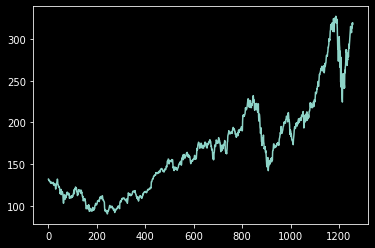

In [77]:
df1 = df.reset_index()['close']
plt.plot(df1)

In [78]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [79]:
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1), :1]

In [80]:
training_size,test_size

(817, 441)

In [81]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  # i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [82]:
time_step = 3
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [83]:
print(X_train.shape), print(y_train.shape)

(813, 3)
(813,)


(None, None)

In [84]:
print(X_test.shape), print(ytest.shape)

(437, 3)
(437,)


(None, None)

In [85]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [86]:
state = (0, 0)
train_step(X_train, y_train, state)

SystemExit: (3, 1)

C:\Users\Sulai\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3369: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
